In [ ]:
# Importing necessary libraries 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


In [ ]:
!pip install timm

     |████████████████████████████████| 346 kB 835 kB/s eta 0:00:01


In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

class Config:
    model_name='tf_efficientnet_b0'
    pretrained=True
    num_classes=2
    train_batch_size=64
    val_batch_size=64
    test_batch_size=64    
    img_size=128
    learning_rate=3e-3
    focal_loss_gamma=2
    scheduler_gamma=0.1
    scheduler_step_size=2000
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cfg=Config()  

In [ ]:
import random

def seed_everything(seed):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
seed_everything(42)

In [ ]:
import timm
class Efficient_model(nn.Module):
    
    def __init__(self, num_classes=cfg.num_classes, model_name=cfg.model_name, pretrained=cfg.pretrained):
        super(Efficient_model, self).__init__()
        self.model=timm.create_model(model_name, pretrained=pretrained, in_chans=3)

        self.model.classifier=nn.Linear(self.model.classifier.in_features, num_classes)
  
    def forward(self,x):
        x = self.model(x)
        return x

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

aug_list=[  A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.Resize(cfg.img_size,cfg.img_size,always_apply=True),
            ToTensorV2(),
         ]

def get_train_transform():
    
    return A.Compose(aug_list,p=1.)


def get_val_transform():
    val_aug_list=[
             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
             A.Resize(cfg.img_size,cfg.img_size,always_apply=True),
             ToTensorV2(),
             ]
    return A.Compose(val_aug_list,p=1.)
    

In [ ]:
from PIL import Image

# MaskDataset for reading the data from source

class MaskDataset(Dataset):
    
    def __init__(self,df,transform=None):
                
        self.df = df  
        self.transform=transform()
        
    def __len__(self):
        return len(self.df) 
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        
        target = item['label'] 
        img = (cv2.imread(item['image_path'])[:,:,::-1]) # converting the images to numpy array 
        if self.transform:
            img=self.transform(image=img)['image']
        return img.float(), torch.tensor(target).long()

In [ ]:
paths = ['../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/',
         '../input/face-mask-dataset/data/','../input/face-mask-lite-dataset/',
        '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/',
        '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/',
        '../input/face-mask-data/face_mask_data/']

mask=[]
nomask=[]
for path in paths:
    if path in '../input/face-mask-dataset/data/' :
        with_mask_list=glob(path+'with_mask/*.jpg')
        without_mask_list=glob(path+'without_mask/*.jpg')
    elif  path in '../input/face-mask-lite-dataset/':
        with_mask_list=glob(path+'with_mask/*.png')
        without_mask_list=glob(path+'without_mask/*.png')
    elif path in '../input/face-mask-data/face_mask_data/':
        with_mask_list=glob(path+'with_mask/*.jpg')
        without_mask_list=glob(path+'without_mask/*.jpg')        
    else:
        with_mask_list=glob(path+'WithMask/*.png')
        without_mask_list=glob(path+'WithoutMask/*.png')

    mask+=with_mask_list
    nomask+=without_mask_list
target_mask=np.ones(len(mask))
target_nomask=np.zeros(len(nomask))
images_path=mask+nomask
targets=np.concatenate([target_mask,target_nomask])
df=pd.DataFrame()
df['image_path']=images_path
df['label']=targets


In [ ]:
from sklearn.model_selection import train_test_split
train_df,val_df=train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
# Defining train data, validation data, test data


train_data = MaskDataset(train_df,get_train_transform)
val_data = MaskDataset(val_df,get_train_transform)

train_loader = DataLoader(train_data, batch_size=cfg.train_batch_size, shuffle=True, num_workers=0) 
val_loader = DataLoader(val_data, batch_size=cfg.val_batch_size, shuffle=True, num_workers=0) 


In [ ]:
train_data.__len__()

31528

In [ ]:
val_data.__len__()

7882

tensor(1)


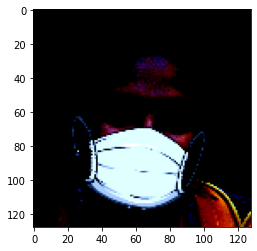

In [ ]:
im, label = train_data[31070]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

tensor(0)


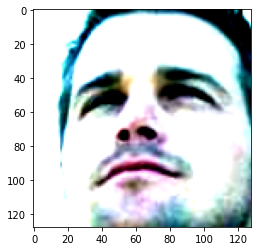

In [ ]:
im, label = val_data[100]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
loss_fn=nn.CrossEntropyLoss()
model=Efficient_model().to(cfg.device)
optimizer = Adam(model.parameters(), lr=cfg.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=cfg.scheduler_gamma, 
                                            step_size=cfg.scheduler_step_size)
scaler = GradScaler()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


In [ ]:
def load_checkpoint_(path,model,optimizer,scheduler,device):
    checkpoint = torch.load(path,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer!=None and scheduler !=None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])    
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    
    print(f'epoch={epoch}, val_loss={val_loss} ')

def load_checkpoint(path,model,device):
    
    checkpoint = torch.load(path,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print('...loading model ', end='')

    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']

    print(f'epoch={epoch}, val_loss={val_loss} ', end='')

    if  'f1_score' in checkpoint :
        f1_score=checkpoint["f1_score"]
        print(f'F1-score={f1_score}')    


def save_checkpoint(epoch,val_loss,model,optimizer,scheduler,path):
    checkpoint={
                'epoch': epoch,
                'val_loss':val_loss,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()
                }
    torch.save(checkpoint,path)

In [ ]:
import time
from tqdm.notebook import tqdm
import gc

class Trainer:
    def __init__(self, train_dataloader, valid_dataloader,
                       model, optimizer,scheduler ,
                       loss_fn, val_loss_fn, agc=False, device="cuda:0"):
        """
        Constructor for Trainer class
        """
        self.model=model
        self.train_loader = train_dataloader
        self.valid_loader = valid_dataloader
        self.optimizer = optimizer
        self.scheduler=scheduler
        self.loss_fn = loss_fn
        self.val_loss_fn = val_loss_fn
        self.device = device
        self.agc = agc
    
    def train_one_epoch(self):
        """
        Runs one epoch of training, backpropagation and optimization
        """
        self.model.train()
        train_prog_bar = tqdm(self.train_loader, total=len(self.train_loader))

        all_train_labels = []
        all_train_preds = []
        
        running_loss = 0
        t = time.time()
        for xtrain, ytrain in train_prog_bar:
            xtrain = xtrain.to(self.device).float()
            ytrain = ytrain.to(self.device)
            
            with autocast():
                # Get predictions
                z = model(xtrain)

                # Training
                train_loss = self.loss_fn(z, ytrain)
                scaler.scale(train_loss).backward()
                
                if self.agc:
                    adaptive_clip_grad(model.parameters(), clip_factor=0.01, eps=1e-3, norm_type=2.0)
                
                scaler.step(self.optimizer)
                scaler.update()
                self.optimizer.zero_grad(set_to_none=True)
                self.scheduler.step()
                # For averaging and reporting later
                running_loss += train_loss.detach().item()

                # Convert the predictions and corresponding labels to right form
                train_predictions = z.detach().cpu().numpy()
                train_labels = ytrain.detach().cpu().numpy()

                # Append current predictions and current labels to a list
                all_train_labels += [train_predictions]
                all_train_preds += [train_labels]

            # Show the current loss to the progress bar
            train_pbar_desc = f'loss: {train_loss.item():.4f}'
            train_prog_bar.set_description(desc=train_pbar_desc)
        
        # Now average the running loss over all batches and return
        train_running_loss = running_loss / (len(self.train_loader))
        print(f"Training Loss: {train_running_loss:.4f} "+
              f"Learning Rate: {self.scheduler.get_last_lr()[0]:.7f}")
        elapsed_time=time.time() - t
        # Free up memory
        del all_train_labels, all_train_preds,train_predictions, train_labels,xtrain, ytrain, z
        
        gc.collect()
        torch.cuda.empty_cache()
        
        return train_running_loss,elapsed_time

    def valid_one_epoch(self):
        """
        Runs one epoch of prediction
        """        
        self.model.eval()
        
        valid_prog_bar = tqdm(self.valid_loader, total=len(self.valid_loader))
        
        with torch.no_grad():
            all_valid_labels = []
            all_valid_preds = []
            
            running_loss = 0
            t = time.time()
            
            for xval, yval in valid_prog_bar:
                xval = xval.to(self.device).float()
                yval = yval.to(self.device)
                
                val_z = self.model(xval)
                
                val_loss = self.val_loss_fn(val_z, yval)
                
                running_loss += val_loss.item()
                
                val_label = yval.detach().cpu().numpy()
                val_pred=torch.argmax(F.softmax(val_z,dim=-1),axis=-1)
                val_pred = val_pred.detach().cpu().numpy()
                
                all_valid_labels += [val_label]
                all_valid_preds += [val_pred]
            
                # Show the current loss
                valid_pbar_desc = f"loss: {val_loss.item():.4f}"
                valid_prog_bar.set_description(desc=valid_pbar_desc)
            
            # Get the final loss
            final_loss_val = running_loss / len(self.valid_loader)
            
            # Get Validation Accuracy
            all_valid_labels = np.concatenate(all_valid_labels)
            all_valid_preds = np.concatenate(all_valid_preds)
            
            print(f"Validation Loss: {final_loss_val:.4f} ")
            elapsed_time=time.time() - t
            
            # Free up memory
            del  xval, yval, val_z
            gc.collect()
            torch.cuda.empty_cache()
            
        return final_loss_val,elapsed_time,all_valid_labels, all_valid_preds
    
    
       
    
    def load_checkpoint(self,path):
        checkpoint = torch.load(path,map_location=cfg.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        print('...loading model ', end='')
        if self.optimizer!=None :
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print('...loading optimizer ' , end='')
        if self.scheduler !=None:  
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])    
            print('...loading scheduler ')

        epoch = checkpoint['epoch']
        val_loss = checkpoint['val_loss']
    
        print(f'epoch={epoch}, val_loss={val_loss} ', end='')
            
        if  'f1_score' in checkpoint :
            f1_score=checkpoint["f1_score"]
            print(f'F1-score={f1_score}')    

    
    def save_checkpoint(self,epoch,val_loss,f1_score,path):
        checkpoint={
                    'epoch': epoch,
                    'val_loss':val_loss,
                    'f1_score' :f1_score,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict':self.scheduler.state_dict()
                    }
        torch.save(checkpoint,path)   
        
        
def model_paramters_report(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())

    pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"number of parameters = {pytorch_total_params} number of trainable parameters = {pytorch_total_trainable_params} ")      

In [ ]:
train_dataloader=train_loader
valid_dataloader=val_loader

In [ ]:
from sklearn import metrics 


num_epochs = 15 #cfg.epochs
trainer=Trainer(train_dataloader, valid_dataloader,
                model, optimizer,scheduler ,
                loss_fn, loss_fn, agc=False,device=cfg.device)
trainer.load_checkpoint('../input/face-mask-classification-efficientnet-00/model.pth')
best_mertic=0 #np.inf
train_loss_list=[]
val_loss_list=[]
accuracy_list=[]
f1_score_list=[]

for epoch in range(num_epochs):
    train_loss,train_elapsed_time=trainer.train_one_epoch()
    with torch.no_grad():
        val_loss,val_elapsed_time,all_valid_labels, all_valid_preds=trainer.valid_one_epoch()
    print("##########################################################################")
    print(

        f'epoch {epoch}  \n' 
        f'train loss: {(train_loss):.4f}, ' + \
        f'train time: {(train_elapsed_time):.4f} \n'            
        f'val loss: {(val_loss):.4f}, ' + \
        f'val time: {(val_elapsed_time):.4f}'
    )
    
    report=metrics.classification_report(all_valid_labels,all_valid_preds, digits=3,output_dict=True)
    f1_score=report['macro avg']['f1-score']
    accuracy=report['accuracy']

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    accuracy_list.append(accuracy)
    f1_score_list.append(f1_score)
    
    metric=f1_score
    if metric > best_mertic  :
        path=f'model.pth'
        trainer.save_checkpoint(epoch,val_loss,f1_score,path)
        print(f'Saving Checkpoint with val loss={val_loss} f1_score={f1_score}')
        best_mertic=metric
        print(metrics.confusion_matrix(all_valid_labels,all_valid_preds).T)
        print(metrics.classification_report(all_valid_labels,all_valid_preds, digits=3))
       

...loading model ...loading optimizer ...loading scheduler 
epoch=3, val_loss=0.0040939306845546655 F1-score=0.9986031713597447


  0%|          | 0/493 [00:00<?, ?it/s]

Training Loss: 0.0026 Learning Rate: 0.0003000


  0%|          | 0/124 [00:00<?, ?it/s]

Validation Loss: 0.0023 
##########################################################################
epoch 0  
train loss: 0.0026, train time: 1639.6758 
val loss: 0.0023, val time: 364.6636
Saving Checkpoint with val loss=0.0022662498672836534 f1_score=0.9988581172262477
[[3960    4]
 [   5 3913]]
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      3965
           1      0.999     0.999     0.999      3917

    accuracy                          0.999      7882
   macro avg      0.999     0.999     0.999      7882
weighted avg      0.999     0.999     0.999      7882



  0%|          | 0/493 [00:00<?, ?it/s]

Training Loss: 0.0015 Learning Rate: 0.0000300


  0%|          | 0/124 [00:00<?, ?it/s]

Validation Loss: 0.0023 
##########################################################################
epoch 1  
train loss: 0.0015, train time: 1533.7949 
val loss: 0.0023, val time: 337.9709
Saving Checkpoint with val loss=0.002280928678241099 f1_score=0.9989849975503826
[[3959    2]
 [   6 3915]]
              precision    recall  f1-score   support

           0      0.999     0.998     0.999      3965
           1      0.998     0.999     0.999      3917

    accuracy                          0.999      7882
   macro avg      0.999     0.999     0.999      7882
weighted avg      0.999     0.999     0.999      7882



  0%|          | 0/493 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#from IPython.display import FileLink
#FileLink(r'./model.pth')


/kaggle/working/model.pth